In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [44]:
#生成数据
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns = iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    #取前100行数据，第0、1、-1列
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    #print(data)
    return data[:,:2],data[:,-1]

In [45]:
X, y = create_data()
#print(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

[[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]
 [5.4 3.9]
 [4.6 3.4]
 [5.  3.4]
 [4.4 2.9]
 [4.9 3.1]
 [5.4 3.7]
 [4.8 3.4]
 [4.8 3. ]
 [4.3 3. ]
 [5.8 4. ]
 [5.7 4.4]
 [5.4 3.9]
 [5.1 3.5]
 [5.7 3.8]
 [5.1 3.8]
 [5.4 3.4]
 [5.1 3.7]
 [4.6 3.6]
 [5.1 3.3]
 [4.8 3.4]
 [5.  3. ]
 [5.  3.4]
 [5.2 3.5]
 [5.2 3.4]
 [4.7 3.2]
 [4.8 3.1]
 [5.4 3.4]
 [5.2 4.1]
 [5.5 4.2]
 [4.9 3.1]
 [5.  3.2]
 [5.5 3.5]
 [4.9 3.1]
 [4.4 3. ]
 [5.1 3.4]
 [5.  3.5]
 [4.5 2.3]
 [4.4 3.2]
 [5.  3.5]
 [5.1 3.8]
 [4.8 3. ]
 [5.1 3.8]
 [4.6 3.2]
 [5.3 3.7]
 [5.  3.3]
 [7.  3.2]
 [6.4 3.2]
 [6.9 3.1]
 [5.5 2.3]
 [6.5 2.8]
 [5.7 2.8]
 [6.3 3.3]
 [4.9 2.4]
 [6.6 2.9]
 [5.2 2.7]
 [5.  2. ]
 [5.9 3. ]
 [6.  2.2]
 [6.1 2.9]
 [5.6 2.9]
 [6.7 3.1]
 [5.6 3. ]
 [5.8 2.7]
 [6.2 2.2]
 [5.6 2.5]
 [5.9 3.2]
 [6.1 2.8]
 [6.3 2.5]
 [6.1 2.8]
 [6.4 2.9]
 [6.6 3. ]
 [6.8 2.8]
 [6.7 3. ]
 [6.  2.9]
 [5.7 2.6]
 [5.5 2.4]
 [5.5 2.4]
 [5.8 2.7]
 [6.  2.7]
 [5.4 3. ]
 [6.  3.4]
 [6.7 3.1]
 [6.3 2.3]
 [5.6 3. ]
 [5.5 2.5]
 [5.5 2.6]

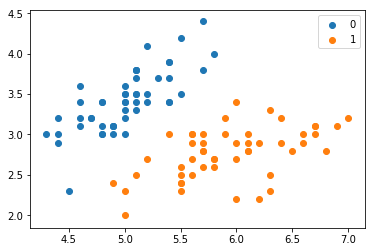

In [42]:
#前50行数据
plt.scatter(X[:50,0],X[:50,1],label='0')
#
plt.scatter(X[50:,0],X[50:,1],label='1')
plt.legend()

In [54]:
class AdaBoost:
    def __init__(self, n_estimators=50, learning_rate=1.0):
        #分类器个数
        self.clf_num = n_estimators
        #学习速率
        self.learning_rate = learning_rate
    
    def init_args(self, datasets, labels):
        self.X = datasets
        self.Y = labels
        self.M, self.N = datasets.shape
        
        #弱分类器集合
        self.clf_sets = []
        #初始化权重weights
        self.weights = [1.0/self.M]*self.M
        #G(x)系数alpha
        self.alpha = []
    
    #记录阀值v,director是阀值方向当为positive使x>v分类为-1,误差率error,使用分类器产生的预测结果
    def _G(self, features, labels, weights):
        m = len(features)
        error = 100000000.0 #无穷大
        best_v = 0.0
        
        #单维features
        features_min = min(features)
        features_max = max(features)
        n_step = (features_max - features_min + self.learning_rate) // self.learning_rate
        
        direct, compare_array = None, None
        for i in range(1, int(n_step)):
            v = features_min + self.learning_rate * i
            if v not in features:
                # 误分类计算
                compare_array_positive = np.array([1 if features[k] > v else -1 for k in range(m)])
                weight_error_positive = sum([weights[k] for k in range(m) if compare_array_positive[k] != labels[k]])
                
                compare_array_nagetive = np.array([-1 if features[k] > v else 1 for k in range(m)])
                weight_error_nagetive = sum([weights[k] for k in range(m) if compare_array_nagetive[k] != labels[k]])

                if weight_error_positive < weight_error_nagetive:
                    weight_error = weight_error_positive
                    _compare_array = compare_array_positive
                    direct = 'positive'
                else:
                    weight_error = weight_error_nagetive
                    _compare_array = compare_array_nagetive
                    direct = 'nagetive'
                    
                # print('v:{} error:{}'.format(v, weight_error))
                if weight_error < error:
                    error = weight_error
                    compare_array = _compare_array
                    best_v = v
        return best_v, direct, error, compare_array
    
    # 计算alpha
    def _alpha(self, error):
        return 0.5 * np.log((1-error)/error)
    
    # 规范化因子
    def _Z(self, weights, a, clf):
        return sum([weights[i]*np.exp(-1*a*self.Y[i]*clf[i]) for i in range(self.M)])
    
    # 权值更新
    def _w(self, a, clf, Z):
        for i in range(self.M):
            self.weights[i] = self.weights[i]*np.exp(-1*a*self.Y[i]*clf[i])/ Z
    
    # G(x)的线性组合
    def _f(self, alpha, clf_sets):
        pass
    
    def G(self, x, v, direct):
        if direct == 'positive':
            return 1 if x > v else -1 
        else:
            return -1 if x > v else 1 
    
    def fit(self, X, y):
        self.init_args(X, y)
        
        for epoch in range(self.clf_num):
            best_clf_error, best_v, clf_result = 100000, None, None
            # 根据特征维度, 选择误差最小的
            for j in range(self.N):
                #选一个特征维度
                features = self.X[:, j]
                # 分类阈值，分类误差，分类结果
                v, direct, error, compare_array = self._G(features, self.Y, self.weights)
                
                if error < best_clf_error:
                    best_clf_error = error
                    best_v = v
                    final_direct = direct
                    clf_result = compare_array
                    axis = j
                    
                # print('epoch:{}/{} feature:{} error:{} v:{}'.format(epoch, self.clf_num, j, error, best_v))
                if best_clf_error == 0:
                    break
                
            # 计算G(x)系数a
            a = self._alpha(best_clf_error)
            self.alpha.append(a)
            # 记录分类器
            self.clf_sets.append((axis, best_v, final_direct))
            # 规范化因子
            Z = self._Z(self.weights, a, clf_result)
            # 权值更新
            self._w(a, clf_result, Z)
    
    def predict(self, feature):
        result = 0.0
        for i in range(len(self.clf_sets)):
            axis, clf_v, direct = self.clf_sets[i]
            f_input = feature[axis]
            result += self.alpha[i] * self.G(f_input, clf_v, direct)
        # sign
        return 1 if result > 0 else -1
    
    def score(self, X_test, y_test):
        right_count = 0
        for i in range(len(X_test)):
            feature = X_test[i]
            if self.predict(feature) == y_test[i]:
                right_count += 1
        
        return right_count / len(X_test)

In [46]:
X = np.arange(10).reshape(10, 1)
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])

In [50]:
clf = AdaBoost(n_estimators=3,learning_rate=0.5)
clf.fit(X,y)

epoch:0/3 feature:0 error:0.30000000000000004 v:2.5
epoch:1/3 feature:0 error:0.21428571428571427 v:8.5
epoch:2/3 feature:0 error:0.18181818181818185 v:5.5


In [51]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [58]:
clf = AdaBoost(n_estimators=10, learning_rate=0.2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.36363636363636365

In [57]:
# 100次结果
result = []
for i in range(1, 101):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf = AdaBoost(n_estimators=100, learning_rate=0.2)
    clf.fit(X_train, y_train)
    r = clf.score(X_test, y_test)
    # print('{}/100 score：{}'.format(i, r))
    result.append(r)

print('average score:{:.3f}%'.format(sum(result)))

average score:65.394%


In [62]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.5)
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=100, random_state=None)

scikit-learn实现了两种Adaboost分类算法，SAMME和SAMME.R。SAMME使用对样本集分类效果作为弱学习器权重，而SAMME.R使用了对样本集分类的预测概率大小来作为弱学习器权重。由于SAMME.R使用了概率度量的连续值，迭代一般比SAMME快。

In [63]:
clf.score(X_test, y_test)

0.9393939393939394

In [1]:
#print(X_train)